# Homework 3 - Master's Degrees from all over!
---


## [1] Data collection

## IMPORTING LIBRARIES 

In [ ]:
import os
import requests
from bs4 import BeautifulSoup
import time
from urllib.parse import urlparse, quote

# Append the path to the directory containing the extract_msc_page module so that Python can locate the module regardless of the current working directory.
# Otherwise, the code returns an error since inside the for loops, the current directory changes to read the HTMLs organized in different folders.
sys.path.append('The path to the directory')
# Importing the functions used within the code blocks & saved as modules
from create_folders import create_folders
from download_html import download_html
from scrape_urls import scrape_urls
# import hashlib

## [1.1] Get the list of master's degree courses & [1.2] Crawl master's degree pages

First Approach: Without using any methods to shorten the time

In [ ]:
# Just for conventions
parent_folder = "HTMLs"   # defining the parent folder name, passed to create_folders function
subfolder_prefix = "page "   # the prefix of each folder which is passed to create_folders function

# Threshold to be set for the number of links within each subfolder
# In this way, we maintain the order in which the courses appear per page at https://www.findamasters.com/masters-degrees/msc-degrees
links_per_folder = 15

base_url = "https://www.findamasters.com/masters-degrees/msc-degrees"   # MSc Degrees URL, the one to be scrapped

start_time = time.time()

# Calling the scrape_urls function on the MSc Degrees link.
# Within this function, two more functions (namely, create_folders and download_html) are called.
# Please refer to each function's docstring for comprehensive details on how they work.
urls = scrape_urls(base_url, 400)   # 400 is the argument defining the number of pages to be retrieved

end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time in the first approach:', round(elapsed_time/3600, ndigits=2))

https://www.findamasters.com/masters-degrees/course/3d-design-for-virtual-environments-msc/?i93d2645c19223 <br /> Downloaded: https://www.findamasters.com/masters-degrees/course/3d-design-for-virtual-environments-msc/?i93d2645c19223 <br /> https://www.findamasters.com/masters-degrees/course/accounting-and-finance-msc/?i321d3232c3891 <br /> Downloaded: https://www.findamasters.com/masters-degrees/course/accounting-and-finance-msc/?i321d3232c3891
https://www.findamasters.com/masters-degrees/course/accounting-and-finance-msc/?i280d4409c4025 <br /> Downloaded: https://www.findamasters.com/masters-degrees/course/accounting-and-finance-msc/?i280d4409c4025 <br /> https://www.findamasters.com/masters-degrees/course/accounting-accountability-and-financial-management-msc/?i132d7816c25522 <br /> Downloaded: https://www.findamasters.com/masters-degrees/course/accounting-accountability-and-financial-management-msc/?i132d7816c25522 <br /> https://www.findamasters.com/masters-degrees/course/accounting-financial-management-and-digital-business-msc/?i345d4286c351 <br /> Downloaded: https://www.findamasters.com/masters-degrees/course/accounting-financial-management-and-digital-business-msc/?i345d4286c351 <br /> https://www.findamasters.com/masters-degrees/course/actuarial-management-msc/?i393d8527c62946 <br /> Downloaded: https://www.findamasters.com/masters-degrees/course/actuarial-management-msc/?i393d8527c62946
https://www.findamasters.com/masters-degrees/course/actuarial-science-msc/?i393d8527c62945 <br /> Downloaded: https://www.findamasters.com/masters-degrees/course/actuarial-science-msc/?i393d8527c62945 <br /> https://www.findamasters.com/masters-degrees/course/addictions-msc/?i132d4318c27100 <br /> Downloaded: https://www.findamasters.com/masters-degrees/course/addictions-msc/?i132d4318c27100 <br /> https://www.findamasters.com/masters-degrees/course/adult-and-mental-health-nursing-pre-registration-msc/?i393d8906c42735 <br /> Downloaded: https://www.findamasters.com/masters-degrees/course/adult-and-mental-health-nursing-pre-registration-msc/?i393d8906c42735 <br /> https://www.findamasters.com/masters-degrees/course/adult-nursing-pre-registration-msc/?i393d8906c27810 <br /> Downloaded: https://www.findamasters.com/masters-degrees/course/adult-nursing-pre-registration-msc/?i393d8906c27810 <br /> https://www.findamasters.com/masters-degrees/course/advanced-chemical-engineering-msc/?i321d8433c50447 <br /> Downloaded: https://www.findamasters.com/masters-degrees/course/advanced-chemical-engineering-msc/?i321d8433c50447 <br /> https://www.findamasters.com/masters-degrees/course/advanced-clinical-practice-msc/?i393d8906c58078 <br /> Downloaded: https://www.findamasters.com/masters-degrees/course/advanced-clinical-practice-msc/?i393d8906c58078 <br /> https://www.findamasters.com/masters-degrees/course/advanced-mechanical-engineering-msc/?i393d8904c6642 <br /> Downloaded: https://www.findamasters.com/masters-degrees/course/mathematics-and-modelling-master-programme-specialization-mathematical-statistics-and-financial-mathematics/?i2112d8646c66553 <br /> Scraped page 400 <br /> Elapsed time in the first approach: 6.44

The output of this cell is deleted since it was very long. Just to show how the code works, we put a part of the output (the last page with the time elapsed) in the markdown above. It takes hours to completely save courses' links in HTML files. As stated in the last line of this cell output, it took almost 6.5 hours to crawl the first 400 pages of the given website. This code averagely retrieves 25 links before which the server responds 429 as the status code. As defined in the download_html function, it waits consecutively for 3-second intervals to receive a 200 response and again continues to save the HTML files.

In [ ]:
# Saving the list of URLs (urls, a.k.a the output of the scrape_urls function) as a txt file
with open('MSc_URLs.txt', 'w', encoding='utf-8') as file:   # Passing 'w' argument for write mode
    for url in urls:
        file.write(url + '\n')   # Using '\n' to put each link in separate line

## [1.3] Parse downloaded pages

In [ ]:
# Append the path to the directory containing the extract_msc_page module so that Python can locate the module regardless of the current working directory.
# Otherwise, the code returns an error since inside the for loops, the current directory changes to read the HTMLs organized in different folders.
sys.path.append('The path to the directory')

# Importing the functions used within the code blocks & saved as a module
from extract_msc_page import extract_msc_page

In [ ]:
results = []   # Define a list to save parsed data from each link

# Specify the path to the parent directory containing all folders (containing saved HTML files)
parent_directory = 'The path to the directory'

# Iterate over each folder in the parent directory
for folder_name in os.listdir(parent_directory):
    folder_path = os.path.join(parent_directory, folder_name)

    # Check if the current item is a directory
    if os.path.isdir(folder_path):
        os.chdir(folder_path)   # Change directory to each of 400 folders

        # Iterate through each file in the folder to scrape the data with the extract_msc_page function
        for file_name in os.listdir(folder_path):
            result_msc = extract_msc_page(file_name)   # Please refer to each function's docstring for comprehensive details on how they work.
            results.append(result_msc)   # Append the scraped data to the predefined list

In [ ]:
# Saving the results to a pandas dataframe
results_dataframe = pd.DataFrame.from_records(results)
results_dataframe.head(10)   # Check for any possible mistakes

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
0,3D Design for Virtual Environments - MSc,Glasgow Caledonian University,School of Engineering and Built Environment,Full time,3D visualisation and animation play a role in ...,September,Please see the university website for further ...,MSc,1 year full-time,Glasgow,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
1,"Accounting, Accountability & Financial Managem...",King’s College London,King’s Business School,Full time,"Our Accounting, Accountability & Financial Man...",September,Please see the university website for further ...,MSc,1 year FT,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
2,Accounting and Finance (MSc),University of Bath,School of Management,Full time,Develop in-depth knowledge of accounting and f...,September,Please see the university website for further ...,MSc,1 year full-time,Bath,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
3,Accounting and Finance - MSc,University of Leeds,Leeds University Business School,Full time,Businesses and governments rely on sound finan...,September,"UK: £18,000 (Total)International: £34,750 (Total)",MSc,1 year full time,Leeds,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
4,"Accounting, Financial Management and Digital B...",University of Reading,Henley Business School,Full time,Embark on a professional accounting career wit...,September,Please see the university website for further ...,MSc,1 year full time,Reading,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
5,Actuarial Management MSc,"City, University of London",Faculty of Actuarial Science and Insurance,Full time,The Actuarial Management master's course is fu...,September,Please see the university website for further ...,MSc,"1 year full time, 2 years part time",London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
6,Actuarial Science MSc,"City, University of London",Faculty of Actuarial Science and Insurance,Full time,The MSc in Actuarial Science will prepare you ...,September,Please see the university website for further ...,MSc,1 year full time,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
7,Addictions MSc,King’s College London,"Institute of Psychiatry, Psychology and Neuros...",Full time,Join us for an online session for prospective ...,September,Please see the university website for further ...,MSc,One year FT,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
8,Adult and Mental Health Nursing (pre-registrat...,"City, University of London",School of Health and Psychological Sciences,Full time,Key informationYou will combine detailed theor...,September,Please see the university website for further ...,MSc,3 years full-time,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
9,Adult Nursing (pre-registration) MSc,"City, University of London",School of Health and Psychological Sciences,Full time,Key informationOn this master in nursing you w...,September,Please see the university website for further ...,MSc,2 years (minimum) full time,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...


In [ ]:
output_dir = 'The path to the directory'   # Defining path for saving TSVs
os.chdir(output_dir)

# Iterate over each element of the resulting list and create a TSV file for each of them
for i, element in enumerate(results, start=1):
    filename = f'course_{i}.tsv'   # Composing the name of the file using f-string method
    with open(filename, 'w', newline='', encoding='utf-8') as tsvfile:   # Passing 'w' argument for write mode
        tsvfile.write('\t'.join(str(value) for value in element.values()))   # Using '\t' to tab-separate the values in TSVs

---
## [2] Search Engine

### [2.0] Preprocessing the text

We use the nltk library to preprocess the dataset before using it. 

First of all we take a look at the dataset and see how it looks like. In particular we print all the unique values for the columns `isitFullTime`, `startDate`, `duration`, `administration` because they must be categorical variables.

Mayvbe check concordancy between `isItFullTime` and `duration`

The column `description`  will be preprocessed with the following operations:
  1. Removing punctuation 
  2. Tokenization
  2. Removing stopwords
  3. Stemming
  4. Lowering the case of all the words

## IMPORTING LIBRARIES 

In [ ]:
import pandas as pd
import numpy as np
import regex as re
import heapq
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from importlib import reload  # To reload the imported modules

# Importing our custom modules for currency conversion
from modules import currency

# Importing our custom modules for ceating the index
from modules import engine_v1, engine_v2, engine_v3
reload(engine_v1)
reload(engine_v2)
reload(engine_v3)

# Setting the NLTK environment to work with English language
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
stops = set(stopwords.words('english'))

porterStemmer = PorterStemmer()


# To display all columns and not only a sample
pd.set_option('display.max_columns', None)

dataset_folder = "data/TSVs/"

---
## [1] Data collection

In [ ]:
# First of all we import all the files and we create a single big dataframe to understand the data

tsv_files_name = [x for x in os.listdir(dataset_folder) if x.endswith(".tsv")]

df = pd.DataFrame()

col_names = ['courseName','universityName','facultyName', 'isItFullTime','description','startDate','fees','modality','duration','city','country','administration','url']

for file_name in tsv_files_name:
  # Read the i-th course_i.tsv file
  try:
    df_course = pd.read_csv(dataset_folder + file_name, sep='\t', names = col_names, header=None)
    # Retrive and add the index
    df_course['index'] = int(file_name.split("_")[1].split(".")[0])
    df_course.set_index('index', inplace=True) 
    # Append the dataframe to the full dataframe 
    df = pd.concat([df, df_course])
  except Exception as e:
    # Remove the comment to see the file the raise the error
    # print("Error while reading the file: " + file_name)
    pass

# so that we can always use it when given the output of a query
df_original = df.copy()

# Order the dataframe by the index column
df.sort_values(by=['index'], inplace=True)

#Print some sample rows of the dataframe
df

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
index,,,,,,,,,,,,,
1,3D Design for Virtual Environments - MSc,Glasgow Caledonian University,School of Engineering and Built Environment,Full time,3D visualisation and animation play a role in ...,September,Please see the university website for further ...,MSc,1 year full-time,Glasgow,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
2,"Accounting, Accountability & Financial Managem...",King’s College London,King’s Business School,Full time,"Our Accounting, Accountability & Financial Man...",September,Please see the university website for further ...,MSc,1 year FT,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
3,Accounting and Finance (MSc),University of Bath,School of Management,Full time,Develop in-depth knowledge of accounting and f...,September,Please see the university website for further ...,MSc,1 year full-time,Bath,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
4,Accounting and Finance - MSc,University of Leeds,Leeds University Business School,Full time,Businesses and governments rely on sound finan...,September,"UK: £18,000 (Total)International: £34,750 (Total)",MSc,1 year full time,Leeds,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
5,"Accounting, Financial Management and Digital B...",University of Reading,Henley Business School,Full time,Embark on a professional accounting career wit...,September,Please see the university website for further ...,MSc,1 year full time,Reading,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5996,Bioinformatics (MSc/MRes),"Birkbeck, University of London",School of Natural Sciences,Full time,Our MSc Bioinformatics provides you with high-...,"October, January",Please see the university website for further ...,MSc,1 year full-time or 2 years part-time,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
5997,"Bioinformatics MSc, PgDip",University of Edinburgh,School of Biological Sciences,Full time,Programme descriptionBioinformatics is an inte...,September,Tuition fees vary between degree programmes. F...,PGDip,"MSc: 1 year full-time, PgDip: 9 months full-time",Edinburgh,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
5998,Bioinformatics (with Advanced Practice) MSc,Teesside University,School of Health & Life Sciences,Full time,As biological sciences have become more data d...,"September, January",Please see the university website for further ...,MSc,"September enrolment: 20 months, including a su...",Middlesbrough,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...


In [ ]:
# Now we finally focus on preprocessing the 'description' column

# We subtitute the NaN values with an empty string
df.fillna('', inplace = True)

# We lower the case of all the words
df['prep_description'] = df['description'].apply(lambda text: text.lower())

# REMOVE PUNCTUATION using regex
# # n particular we substitute all the punctuation with an empty string, avoiding to remove the dashes inside the words
# The regex has tre filters: 
# - the first eliminates everything that is not a letter, a number, a space or a dash
# - the second and the third eliminate the dashes that are not between two letters
# Some examples: eye- --> eye, -eye --> eye, eye-catching --> eye-catching

def remove_punctuation(text):
    # Sometime raises TypeError: expected string or buffer
    # So we must check that it's a string before removing punctuation
    if isinstance(text, str):
        return re.sub(r"[^a-zA-Z0-9\s\-]|((?<=[a-zA-Z\W])\-(?=[^a-zA-Z]))|((?<=[^a-zA-Z])\-(?=[a-zA-Z\W]))", "", text)
    else:
        return text

# Apply the function to 'description' column
df['prep_description'] = df['prep_description'].apply(remove_punctuation)

# TOKENIZATION using the word_tokenize() function of NLTK
df['prep_description'] = df['prep_description'].apply(lambda text: nltk.word_tokenize(text))


# REMOVING STOPWORDS using the stopwords list of NLTK
df['prep_description'] = df['prep_description'].apply(lambda words: [x for x in words if x not in stops] )


# STEMMING using the PorterStemmer of NLTK
porterStemmer = PorterStemmer()
df['prep_description'] = df['prep_description'].apply(lambda words: [porterStemmer.stem(x) for x in words])

In [ ]:
# First of all we check if every record has only one currency symbol inside
# Instead of using re we use regex, because supports unicode characters
# We use the unicode character class \p{Sc} to match any currency symbol
# print("Max number of currency symbols in a record: ", df['fees'].apply(lambda x: len(list(set(re.findall(r"\p{Sc}", x)))) if isinstance(x, str) else None).max())
# The result is 1, so we can assume that every record has only one currency symbol

# Since we have only one currency symbol then we can store it in a series
currency_code = pd.Series()

def extract_currency(text):
  lst_currency = list(set(re.findall(r"\p{Sc}", str(text))))
  return lst_currency[0] if len(lst_currency) > 0 else None
  
currency_code = df['fees'].apply(extract_currency)
# Setting nan values to None
currency_code[currency_code.isna()] = None
print("List of all currencies: ", currency_code.unique())

# Then we look for numbers in the 'fees' column. Again, we use regexp to match
# numbers because, between digits, there can be symbols like ' or , or .
# With this regexp we are not able to match numbers only with at least than 3 digits
# We write a function to do that
def find_fees(text: str) -> float:
  """ 
  This function returns the maximum number found in the text passed as input
  Args:
    text: the text to search in
  Return:
      the maximum number found in the text or empty string if no number is found
  """
  global currency_code
  
  pattern = r'(?:€|\$|£)\s*\d+(?:[.,]\d+)?|\d+(?:[.,]\d+)?\s*(?:€|\$|£)'
  results = re.findall(pattern, str(text))
  if len(results) > 0:
    # Remove the currency symbol from the matched strings
    results = [re.sub(r"\p{Sc}", "", x) for x in results]
    # Remove punctuation from the matched strings and then convert them to float
    results = [float(re.sub(r"[\'\.\,\s]", "", x)) for x in results]
    return max(results)
  else:
    return ''

fees = pd.Series(data = df['fees'].apply(find_fees), index = df.index, name='fees', dtype='float64')

# Finally we create a new column 'feesEUR' that contains the fees converted in EUR
# We use our custom python modue 'currency' to do that
df['feesEUR'] = fees
df['feesEUR'] = df.apply(lambda x: currency.convert_to_EUR(x['feesEUR'], currency_code[x.name]) if x['feesEUR'] != '' else '', axis = 1)

List of all currencies:  [None '£' '€' '$']


In [ ]:
print("Percentage of non empty fees: ", round(df[df['feesEUR'] != '']['feesEUR'].count() / df.shape[0] * 100, 1), '%')

Percentage of non empty fees:  19.4 %


### [2.1] Conjunctive query

#### [2.1.1] Create your index!

Most of the function that we implemented in this section are in the module `engine_v1`. Here we report a brief description. Read the comments in the `engine_v1.py` module further details.

> The module `engine_v1` has the following methods: 
> * `create_vocabulary(df: pd.DataFrame) -> dict`   
>
>   (Creates the vocabulary. **This function must be called to initializate the Search Engine**. It saves two files: `vocabulary.json` and `vocabulary_inverted.json`. The first associates a word with its integer index, while the second does the opposite)
>
> * `get_vocabulary() -> dict`
>
>   (Retrives the vocabulary (word -> term_id) from the saved file `vocabulary.json`)
>
> * `get_vocabulary_inverted() -> dict`
>
>   (Retrives the inverted vocabulary (term_id -> word) from the saved file `vocabulary_inverted.json`)
>
> * `get_term_id(word: str) -> int:`
>
>   (From a word get the corresponding term_id)
>
> * `get_word_from_id(term_id: int) -> str:`
>
>   (From a term_id get the corresponding word)
>
> * `create_inverted_index() -> dict:`
>
>   (Creates the inverted index and saves it in the file `inverted_index.json`)
>
> * `get_inverted_index() -> dict:`
>
>   (Retrives the inverted index from the file `inverted_index.json`)
>
> * `preprocess(text: str) -> list:`
>
>   (Preprocesses a string, in our case it's used to preprocess the query)
>
> * `search(query: str) -> pd.DataFrame:`
>
>   (Given a query it outputs the documents that contains all the words in the preprocessed query)
> 

The first time that we call the Search Engine (v1) we pass the entire dataframe to it. The dataframe must have a column named `prep_description`, that is the preprocessed version of the coumn `description`.

So we create the vocabulary that contains a dictionary mapping each word (in the description field) to an integer `term_id` (this will initializate the Search Engine).

In [ ]:
# Create vocabulary
vocabulary = engine_v1.create_vocabulary(df)

Now we focus on creating the inverted index. 

We create a new dictionary where the index is the `term_id` and as values has the indexes of the courses that cointain that word.

This process is done using the function `create_inverted_index()` in our module `engine_v1`.

In [ ]:
# Create inverted index
inverted_index = engine_v1.create_inverted_index()

#### [2.1.2] Execute the query

In [ ]:
## Uncomment the following two lines for manually inputting the query
# print("Input the query: ")
# query = input()

# An example of query
query = "advanced knowledge"

df_result = engine_v1.search(query)

# Showing, at most, the first 10 results of the query
df_result[['courseName','universityName','description','url']][:10]

,courseName,universityName,description,url
index,,,,
4,Accounting and Finance - MSc,University of Leeds,Businesses and governments rely on sound finan...,https://www.findamasters.com/masters-degrees/c...
8,Addictions MSc,King’s College London,Join us for an online session for prospective ...,https://www.findamasters.com/masters-degrees/c...
13,Advanced Mechanical Engineering MSc,"City, University of London",Key informationThis engineering masters progra...,https://www.findamasters.com/masters-degrees/c...
40,Big Data Technologies MSc,University of East London,This programme is ideal if you want to pursue ...,https://www.findamasters.com/masters-degrees/c...
69,Bioinformatics - MSc,University of Bradford,Bioinformatics combines knowledge from a varie...,https://www.findamasters.com/masters-degrees/c...
94,Biomaterials and Tissue Engineering MSc,University College London,Register your interest in graduate study at UC...,https://www.findamasters.com/masters-degrees/c...
95,Biomedical and Analytical Science MSc,University of Huddersfield,The Biomedical and Analytical Science MSc cour...,https://www.findamasters.com/masters-degrees/c...
138,Biomedical Science (Medical Immunology) MSc,Middlesex University,This master's programme will allow you to deve...,https://www.findamasters.com/masters-degrees/c...
179,Bioscience (MSc),KAUST,The Bioscience (B) program plays a key role in...,https://www.findamasters.com/masters-degrees/c...


## [2.2] Conjunctive query & Ranking score

### [2.2.1] Inverted index

Here we use functions of our module `engine_v2`. In this module we 'recycle' some functions on the previous version `engine_v1`. 
Here we report a brief description. Read the comments in the `engine_v2.py` module further details.

> The module `engine_v2` has the following methods: 
>
> * `create_inverted_index(df: pd.DataFrame) -> dict`
>
>   (**This is the first function that must be run in order to initializate the Search Egine v2**. It saves the dataframe and computes the inverted tf-idf index for each word in the vocabulary. Returns a dictionary where the key is the `term_id` and the value is a lsit of tuple. The dictionary is saved in the file `inverted_index_tf_idf.json`)
>
> * `compute_if_idf() -> pd.DataFrame`
>
>   (Computes the tf-idf score for each word in each document (i.e. course) where tf-idf = tf * idf = term frequency * inverse document frequency. We use TfidfVectorizer from sklearn to create the tf-idf matrix. This matrix will be saved in the file `courses_matrix_tf_idf.csv` to access it later. This function also computes the norm of each document and stores them in  Returns the correspondent tf-idf dataframe `inverted_index_tf_idf.json`)
>
> * `get_tf_idf() -> pd.DataFrame`
>
>   (This function reads the `courses_matrix_tf_idf.csv` and returns the tf-idf dataframe)
>
> * `get_norms() -> pd.DataFrame`
>
>   (Retrives the precomputed l2 norms of the documents from the file `norms.csv`)
>
> * `search(query: str, k: int) -> list`
>
>   (Given a query, this function outputs the `k` most simlar documents to the query by the cosine similarity score. It is applied to the `description` column of the dataset (among the documents that contains all the words in the preprocessed query))
> 

In [ ]:
inverted_index_tf_idf = engine_v2.create_inverted_index(df)

#### [2.2.2] Execute the query

In [ ]:
# ## Uncomment the following two lines for manually inputting the query
# # print("Input the query: ")
# # query = input()

# An example of query
query = "data science"

heap_result = engine_v2.search(query, k = 10)

# 'Popping' all the element from the heap to build the DataFrame
df_results = pd.DataFrame(columns = ['index'] + df.columns.tolist() + ['Similarity'])
if heap_result is not None:
  for _ in range(len(heap_result)):
    similarity, elem = heapq.heappop(heap_result)

    row = pd.DataFrame(data = [elem], columns = ['index'] + df.columns.tolist() + ['Similarity'])
    row.reset_index(drop=True, inplace=True)
    row.set_index('index', inplace=True)
    df_results = pd.concat([df_results, row])

df_results[['courseName','universityName','description','url','Similarity']]


,courseName,universityName,description,url,Similarity
5514,"Data Science and its Applications, MSc",University of Greenwich,Our MSc degree in Data Science and its Applica...,https://www.findamasters.com/masters-degrees/c...,0.735675
1288,Data Science - Master of Science (MS),University of Colorado Boulder,The on-campus Master of Science in Data Scienc...,https://www.findamasters.com/masters-degrees/c...,0.639597
1388,Data Science MSc,University of Greenwich,Our MSc in Data Science equips graduates to em...,https://www.findamasters.com/masters-degrees/c...,0.631615
1380,Data Science MSc,Coventry University,Data is everywhere. As the volume and complexi...,https://www.findamasters.com/masters-degrees/c...,0.573999
1290,Data Science - MSc,University of Glasgow,The Masters in Data Science is a specialist ve...,https://www.findamasters.com/masters-degrees/c...,0.573040
1311,Data Science (MSc),"Birkbeck, University of London",Our intensive MSc Data Science is designed for...,https://www.findamasters.com/masters-degrees/c...,0.555825
1303,Data Science - MSc/PgD/PgC,Cardiff Metropolitan University,This Master's degree in Data Science is an ind...,https://www.findamasters.com/masters-degrees/c...,0.533358
4396,Master in Applied Data Science,Frankfurt School of Finance and Management,OverviewThe Master in Applied Data Science is ...,https://www.findamasters.com/masters-degrees/c...,0.527461
4750,Master of Science in Data Science and Business...,Asia Pacific University of Technology & Innova...,This programme is specifically designed to pro...,https://www.findamasters.com/masters-degrees/c...,0.524028
1297,Data Science - MSc,University of Bristol,If you want to improve the world through the r...,https://www.findamasters.com/masters-degrees/c...,0.523106


---
## [3] Define a new score!

Our new score is based on the columns `courseName` and `description`. The aim is to give more importance to the words in the course name field. This is because that field represent a more 'reliable' and coincise summary.

The score definition is the following:
> $$Score = TF_{courseName} + (1 + log(TF_{description})) * IDF_{description} $$

We give a lot of importance to the word inside the `courseName`. We add to that 'partial' score the sublinear-TF_IDF score of the `description` column. The log is used to reduce the importance of the words that appear more frequently in the course description. 

We put the new code inside the `engine_v3` module, using the code of the Search Engine v1 as much as possible.

The functions are the same as the module `engine_v2`, but the implementation is a bit different. That's why we do not list here their definitions.

The two most important functions of `engine_v3` are the following:
> * `engine_v3.create_inverted_index(df:pd.DataFrame) -> dict` 
> (*This function is the one that must be called to start the Search Engine v3*)
>
> * `enginev3.search(query: str, k: int) -> list`
> (The query function that gives as output a heap with the k most similar results)
>


In [ ]:
inverted_index_tf_idf = engine_v3.create_inverted_index(df)

In [ ]:
# Example query
query = "data science"

heap_result = engine_v3.search(query, k = 10)

# 'Popping' all the element from the heap to build the DataFrame
df_results = pd.DataFrame(columns = ['index'] + df.columns.tolist() + ['Similarity'])
if heap_result is not None:
  for _ in range(len(heap_result)):
    similarity, elem = heapq.heappop(heap_result)

    row = pd.DataFrame(data = [elem], columns = ['index'] + df.columns.tolist() + ['Similarity'])
    row.reset_index(drop=True, inplace=True)
    row.set_index('index', inplace=True)
    df_results = pd.concat([df_results, row])

df_results[['courseName','universityName','description','url','Similarity']]



,courseName,universityName,description,url,Similarity
1303,Data Science - MSc/PgD/PgC,Cardiff Metropolitan University,This Master's degree in Data Science is an ind...,https://www.findamasters.com/masters-degrees/c...,0.809008
1286,Data Science,Politecnico di Milano,Big Data can provide important insights into b...,https://www.findamasters.com/masters-degrees/c...,0.782615
1287,Data Science,Aalto University,Big Data can provide important insights into b...,https://www.findamasters.com/masters-degrees/c...,0.782615
1306,Data Science (DSC),Budapest University of Technology and Economics,Big Data can provide important insights into b...,https://www.findamasters.com/masters-degrees/c...,0.782615
1307,Data Science (DSC),Eotvos Lorand University,Big Data can provide important insights into b...,https://www.findamasters.com/masters-degrees/c...,0.782615
1285,Data Science,University of Padua,heMaster's degree in Data Scienceprepares stud...,https://www.findamasters.com/masters-degrees/c...,0.778809
1329,Data Science (PgCert/PgDip/MSc),Robert Gordon University,The MSc Data Science degree at Robert Gordon U...,https://www.findamasters.com/masters-degrees/c...,0.774455
4068,MA in Data Science,Fulda University of Applied Sciences,Data Science is a field which is increasingly ...,https://www.findamasters.com/masters-degrees/c...,0.766533
1290,Data Science - MSc,University of Glasgow,The Masters in Data Science is a specialist ve...,https://www.findamasters.com/masters-degrees/c...,0.736853
1391,Data Science MSc,Sabanci University,Data Science Master`s Degree Program aims to p...,https://www.findamasters.com/masters-degrees/c...,0.734632


In order to compare the new score and the tf-idf score, we run the Search Engine v2 and v3 with the query `data science` and we show in the following image the first ten results. Above there is the output of Search Engine v2, while below there is the Search Engine v3:

![Comparing the two score](images/score-compare.png)

How score rewards the courses that have all the query words in their name. That's the main reason why the similarity score are higher for this score. Moreover if we had not limited ourselves to printing only the first 10 results, we would have seen that the less relevant results have a lower score. This means that they contain the query words only in the course description, which does not make it take a more relevant result in the output. 

In the end, looking at the course names at first glance I would say that the score we invented gets better results (based on our demands) than TF-IDF.

---
## [4] Visualizing the most relevant MSc degrees

## IMPORTING LIBRARIES 

In [ ]:
import folium
from folium.plugins import MarkerCluster, Fullscreen, TagFilterButton, MiniMap
import geopandas as gpd
import pandas as pd
import numpy as np

## [4.1] Reading query data

In [ ]:
query_result = pd.read_csv('df_result/df_results.csv')
query_result = query_result.loc[query_result['feesEUR'].notna()]   # Dropping the rows with null fee values
query_result.head()

,index,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url,prep_description,feesEUR,Similarity
9,1391,Data Science MSc,Sabanci University,Masters Programmes,Full time,Data Science Master`s Degree Program aims to p...,See Course,$19.500 USD per year,MSc,See website for details.,Istanbul,Turkey,On Campus,https://www.findamasters.com/masters-degrees/c...,"['data', 'scienc', 'master', 'degre', 'program...",17848.970252,0.734632
11,1390,Data Science MSc,University of Wolverhampton,"School of Engineering, Computing and Mathemati...",Full time,"The MSc Data Science is a conversion MSc, desi...","September, March",Home - Full-time - £8395 per yearHome - Part-t...,MSc,"14 months full time, 28 months part time",Wolverhampton,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...,"['msc', 'data', 'scienc', 'convers', 'msc', 'd...",17791.340396,0.724194
15,1369,Data Science for Life Sciences,Hanze University of Applied Sciences,Masters courses,Full time,IntroductionThe Data Science for Life Sciences...,September,"EU/EEA students €2,314non-EU/EEA students €8,2...",MSc,18 Months,Groningen,Netherlands,On Campus,https://www.findamasters.com/masters-degrees/c...,"['introductionth', 'data', 'scienc', 'life', '...",8276.000000,0.714932
16,1298,Data Science - MSc,University of Helsinki,International Masters Degree Programmes,Full time,Goal of the pro­grammeData science combines co...,September,Tuition fee per year (non-EU/EEA students): 15...,MSc,2 years,Helsinki,Finland,On Campus,https://www.findamasters.com/masters-degrees/c...,"['goal', 'programmedata', 'scienc', 'combin', ...",15000.000000,0.712557
23,1330,Data Science (PGCert/PGDip/MSc) - online,University of St Andrews,School of Computer Science,Full time,The Data Science course develops core skills i...,"September, January","MSc (three years) £18,000 (charged £6,000 per ...",PGCert,3 years full time,St Andrews,United Kingdom,NaN,https://www.findamasters.com/masters-degrees/c...,"['data', 'scienc', 'cours', 'develop', 'core',...",20727.775219,0.702306


## [4.2] Geocoding

In [ ]:
# Concat values of 'universityName', 'city', and 'country' columns (containing address data) into a new column to pass to the geocoder
query_result['address'] = query_result[['universityName', 'city', 'country']].apply(lambda row: ','.join(map(str, row)), axis=1)
query_result.head()

,index,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url,prep_description,feesEUR,Similarity,address
9,1391,Data Science MSc,Sabanci University,Masters Programmes,Full time,Data Science Master`s Degree Program aims to p...,See Course,$19.500 USD per year,MSc,See website for details.,Istanbul,Turkey,On Campus,https://www.findamasters.com/masters-degrees/c...,"['data', 'scienc', 'master', 'degre', 'program...",17848.970252,0.734632,"Sabanci University,Istanbul,Turkey"
11,1390,Data Science MSc,University of Wolverhampton,"School of Engineering, Computing and Mathemati...",Full time,"The MSc Data Science is a conversion MSc, desi...","September, March",Home - Full-time - £8395 per yearHome - Part-t...,MSc,"14 months full time, 28 months part time",Wolverhampton,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...,"['msc', 'data', 'scienc', 'convers', 'msc', 'd...",17791.340396,0.724194,"University of Wolverhampton,Wolverhampton,Unit..."
15,1369,Data Science for Life Sciences,Hanze University of Applied Sciences,Masters courses,Full time,IntroductionThe Data Science for Life Sciences...,September,"EU/EEA students €2,314non-EU/EEA students €8,2...",MSc,18 Months,Groningen,Netherlands,On Campus,https://www.findamasters.com/masters-degrees/c...,"['introductionth', 'data', 'scienc', 'life', '...",8276.000000,0.714932,"Hanze University of Applied Sciences,Groningen..."
16,1298,Data Science - MSc,University of Helsinki,International Masters Degree Programmes,Full time,Goal of the pro­grammeData science combines co...,September,Tuition fee per year (non-EU/EEA students): 15...,MSc,2 years,Helsinki,Finland,On Campus,https://www.findamasters.com/masters-degrees/c...,"['goal', 'programmedata', 'scienc', 'combin', ...",15000.000000,0.712557,"University of Helsinki,Helsinki,Finland"
23,1330,Data Science (PGCert/PGDip/MSc) - online,University of St Andrews,School of Computer Science,Full time,The Data Science course develops core skills i...,"September, January","MSc (three years) £18,000 (charged £6,000 per ...",PGCert,3 years full time,St Andrews,United Kingdom,NaN,https://www.findamasters.com/masters-degrees/c...,"['data', 'scienc', 'cours', 'develop', 'core',...",20727.775219,0.702306,"University of St Andrews,St Andrews,United Kin..."


In [ ]:
# Ckeck if there are any null values in the 'address' column
query_result.loc[query_result['address'].isna()]   # OK

,index,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url,prep_description,feesEUR,Similarity,address


In [ ]:
# For encoding geo-information data, we used geopandas which supports geocoding with geopy library.
# Geopy supports different geocoding service providers. At first, we used Nominatim (OpenStreetMap ), but returned Nan values for several addresses.
# Then, we tried OpenCage which perfectly geocoded all the addresses. To use this service, we signed up for an API key which allows 2500 geocoding requests per day.
geocoded_addresses = gpd.tools.geocode(query_result["address"], provider="opencage", api_key="4da63ae7c3534cfea8aa41c69b3c9c8c", user_agent="SSP", timeout=20)
geocoded_addresses.head()
# The result is a GeoDataFrame that contains the original address column and a 'geometry' column containing Shapely Point objects.

,geometry,address
9,POINT (29.37863 40.89272),"Sabancı University, 30 Ağustos Caddesi, 34956 ..."
11,POINT (-2.12756 52.59083),"University of Wolverhampton, Ring Road St. Pet..."
15,POINT (6.56667 53.21917),"Groningen, Netherlands"
16,POINT (24.95355 60.17565),"University of Helsinki, Snellmaninaukio, 00170..."
23,POINT (-2.81179 56.33982),"University of St Andrews, North Street, St And..."


In [ ]:
# Ckeck if there are any null values in the geocoded 'address' column
geocoded_addresses.loc[geocoded_addresses['address'].isna()]   # OK

,geometry,address


In [ ]:
# Since the number of rows as well as their order are the same, we can simply join geocoded_addresses to our query_result dataframe. 
query_geocoded = geocoded_addresses.join(query_result, lsuffix='_geocoded', rsuffix='_res')
query_geocoded.head()
# The output of this step is a geodataframe containing the latitude and longitude for each MSc course.

,geometry,address_geocoded,index,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url,prep_description,feesEUR,Similarity,address_res
9,POINT (29.37863 40.89272),"Sabancı University, 30 Ağustos Caddesi, 34956 ...",1391,Data Science MSc,Sabanci University,Masters Programmes,Full time,Data Science Master`s Degree Program aims to p...,See Course,$19.500 USD per year,MSc,See website for details.,Istanbul,Turkey,On Campus,https://www.findamasters.com/masters-degrees/c...,"['data', 'scienc', 'master', 'degre', 'program...",17848.970252,0.734632,"Sabanci University,Istanbul,Turkey"
11,POINT (-2.12756 52.59083),"University of Wolverhampton, Ring Road St. Pet...",1390,Data Science MSc,University of Wolverhampton,"School of Engineering, Computing and Mathemati...",Full time,"The MSc Data Science is a conversion MSc, desi...","September, March",Home - Full-time - £8395 per yearHome - Part-t...,MSc,"14 months full time, 28 months part time",Wolverhampton,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...,"['msc', 'data', 'scienc', 'convers', 'msc', 'd...",17791.340396,0.724194,"University of Wolverhampton,Wolverhampton,Unit..."
15,POINT (6.56667 53.21917),"Groningen, Netherlands",1369,Data Science for Life Sciences,Hanze University of Applied Sciences,Masters courses,Full time,IntroductionThe Data Science for Life Sciences...,September,"EU/EEA students €2,314non-EU/EEA students €8,2...",MSc,18 Months,Groningen,Netherlands,On Campus,https://www.findamasters.com/masters-degrees/c...,"['introductionth', 'data', 'scienc', 'life', '...",8276.000000,0.714932,"Hanze University of Applied Sciences,Groningen..."
16,POINT (24.95355 60.17565),"University of Helsinki, Snellmaninaukio, 00170...",1298,Data Science - MSc,University of Helsinki,International Masters Degree Programmes,Full time,Goal of the pro­grammeData science combines co...,September,Tuition fee per year (non-EU/EEA students): 15...,MSc,2 years,Helsinki,Finland,On Campus,https://www.findamasters.com/masters-degrees/c...,"['goal', 'programmedata', 'scienc', 'combin', ...",15000.000000,0.712557,"University of Helsinki,Helsinki,Finland"
23,POINT (-2.81179 56.33982),"University of St Andrews, North Street, St And...",1330,Data Science (PGCert/PGDip/MSc) - online,University of St Andrews,School of Computer Science,Full time,The Data Science course develops core skills i...,"September, January","MSc (three years) £18,000 (charged £6,000 per ...",PGCert,3 years full time,St Andrews,United Kingdom,NaN,https://www.findamasters.com/masters-degrees/c...,"['data', 'scienc', 'cours', 'develop', 'core',...",20727.775219,0.702306,"University of St Andrews,St Andrews,United Kin..."


In [ ]:
# Convert values of 'feesEUR' column from numpy.float64 to integers to omit decimals
query_geocoded['feesEUR'] = query_geocoded['feesEUR'].astype(np.int64)

In [ ]:
def fee_cat(fees):
    ''' This function categorizes the fee 
    amounts into 6 categories.
    '''
    if fees < 1000:
        return 'Less than 1000 €'
    elif 1000 <= fees < 5000:
        return '1000 to 5000 €'
    elif 5000 <= fees < 10000:
        return '5000 to 10000 €'
    elif 10000 <= fees < 15000:
        return '10000 to 15000 €'
    elif 15000 <= fees < 20000:
        return '15000 to 20000 €'
    else:
        return 'More than 20000 €'

# Applying the fee_cat function to the 'feesEUR' column and save them into a new column ('fees_Cat')
query_geocoded['fees_Cat'] = query_geocoded['feesEUR'].apply(lambda fee: fee_cat(fee))

## [4.3] Visualization

In [ ]:
# To visualize the most relevant MSc degrees, we created an interactive web map by using the folium package.

# Creating the map object
interactive_map = folium.Map(location=(51.7548, 2), zoom_start=7, control_scale=True)

# Using a dictionary to define colour categories and corresponding fee ranges (similar to the ranges defined in 'fees_Cat' column)
# It is used to add tags for each marker (a.k.a MSc course), which are used for the TagFilterButton on the upper-left side of the map.
color_categories = {'Less than 1000 €': 'green', '1000 to 5000 €': 'pink', '5000 to 10000 €': 'orange',
                    '10000 to 15000 €': 'red', '15000 to 20000 €': 'purple', 'More than 20000 €': 'black'}

# There are multiple overlapping courses. we created a MarkerCluster object to group markers for better visualization.
# The icon_create_function is set to None to use default markers.
marker_cluster = folium.plugins.MarkerCluster(overlay=True, control=False, icon_create_function=None, name='Courses').add_to(interactive_map)

# Creating markers by using a for loop and iterating over query_geocoded rows, as well as adding corresponding tags to each marker
for index, row in query_geocoded.iterrows():
    fees = row['feesEUR']
    category = row['fees_Cat']
    color = color_categories.get(category)   # the value for each category returned from the color_categories dictionary & is used as the marker's colour
    # Creating marker objects within the MarkerCluster
    folium.Marker(location=[row['geometry'].y, row['geometry'].x],  # Using latitude and longitude of the geocoded addresses
                  popup=f"Course Name:\n {row['courseName']} \n Annual Fees:\n {fees} €",  # This is the text that pops up when clicking on each marker (a.k.a MSc course)
                  tooltip="Click me!", icon=folium.Icon(color=color, icon='university', prefix='fa'),  # Customizing the marker icon and color
                  tags=[category]  # This tag will be recognized by the TagFilterButton plugin, thus we can filter our data based on the categories defined above.
                  ).add_to(marker_cluster)  # This adds course markers to the courses FeatureGroup using the MarkerCluster

# Add a button to toggle a fullscreen view of the map under the LayerControl button.
folium.plugins.Fullscreen(position="topright", title="Expand me",
                          title_cancel="Exit me", force_separate_button=True, ).add_to(interactive_map)

# This list is passed to TagFilterButton to identify the tags to be filtered.
categories = ['Less than 1000 €', '1000 to 5000 €', '5000 to 10000 €',
              '10000 to 15000 €', '15000 to 20000 €', 'More than 20000 €']

# Add a button for tag filtering based on the list of fee categories
folium.plugins.TagFilterButton(categories).add_to(interactive_map)

# Add a minimap for easier navigation
folium.plugins.MiniMap(position="bottomleft", zoom_level_offset=-5, toggle_display=True).add_to(interactive_map)


# Saving the map to an HTML file so that it can be opened in any web browser
interactive_map.save('Interactive/interactive_map.html')

# Adding legend
# It turned out that Fulium only has a built-in legend for the choropleth legend. Source: https://github.com/python-visualization/folium/issues/528
# We found out that there are a couple of ways to add a legend to a folium interactive map.
# Among them, we found using HTML is probably the best solution.
# This part of the code is adapted from https://nbviewer.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd
from branca.element import Template, MacroElement

# The Template class allows users to create custom HTML structures with placeholders that can be embedded into Folium maps.
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend </div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:green;opacity:0.7;'></span>Less than 1000 €</li>
    <li><span style='background:pink;opacity:0.7;'></span>1000 to 5000 €</li>
    <li><span style='background:orange;opacity:0.7;'></span>5000 to 10000 €</li>
    <li><span style='background:red;opacity:0.7;'></span>10000 to 15000 €</li>
    <li><span style='background:purple;opacity:0.7;'></span>15000 to 20000 €</li>
    <li><span style='background:black;opacity:0.7;'></span>More than 20000 €</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

# The MacroElement class is used to create a custom map element that incorporates the HTML template defined above by using the Template class. 
macro = MacroElement()
macro._template = Template(template)

# Incorporating the map element (template) into the root of a Folium map, and enabling the display of it on the map.
interactive_map.get_root().add_child(macro)

## How to use the interactive map
Please use the full-screen mode (by clicking the Expand me button) for the best experience. Every time you change the zoom scale, the number of clusters changes too. At the lowest zoom level (fully zoomed out), there is (most probably) one cluster containing all the courses. Clusters are separated out when you zoom closer. When fully zoomed in, you can access the information of the overlapped courses (a.k.a cluster) by clicking on the cluster. There is also a minimap on the bottom-right side of the map to help you find the current location more easily as well as a filter button on the top-left side for selecting courses based on predefined fee ranges.

---
## [6] Command Line Question

First, take the course_i.tsv files you created in point 1 and merge them using Linux commands (Hint: make sure that the first row containing the column names appears only once).

*Estratto di codice da CommandLine.sh*
1. Concatenate all the TSV files into a single file named `merged_courses.tsv`.

    ```bash
    cat course_*.tsv > merged_courses.tsv
    ```

2. Use `awk` to remove duplicate header lines. It keeps only the first occurrence of each line. The result is saved in the file `final_merged_courses.tsv`.

    ```bash
    awk '!a[$0]++' merged_courses.tsv > final_merged_courses.tsv
    ```

3. Concatenate `column_names.tsv` and `final_merged_courses.tsv` to add column names to the final file.

    ```bash
    cat column_names.tsv final_merged_courses.tsv > merged_courses.tsv
    ```


Now that you have your merged file named merged_courses.tsv, use Linux commands to answer the following questions:

* Which country offers the most Master's Degrees? Which city?
* How many colleges offer Part-Time education?
* Print the percentage of courses in Engineering (the word "Engineer" is contained in the course's name).

**LOOK THE CODE IN THE SCRIPT FILE COMMANDLINE.SH**


**Output**

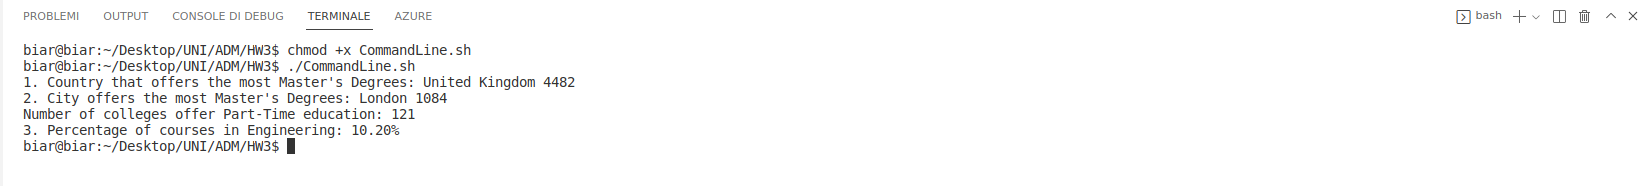

---
## [6] Algorithmic Question

Develop an algorithm to generate a report detailing the number of hours a worker (Leonardo) has worked each day for a specific number of days.

**Input**

The first line of input contains two integers:
- $d$ : the number of days Leonardo worked there;
- $sumHours$: the total number of hours he worked for the company.

Each of the following d lines contains two integer numbers:
- $minTime_{i}$: the minimum hours he can work on the $i_{th}$ day;
-$maxTime_{i}$: the maximum hours he can work on th $i_{th}$ day.

**Output**

- Output '**NO**' if a report cannot be generated.
- Output '**YES**' if a report can be generated, along with the number of hours Leonardo spent each day, indicated in the second line of the output.



In [ ]:
def report_hours ():
  d, sumHours = map(int, input().split())

  # Initialize empty lists to store minimum and maximum hours for each day
  minTime = []
  maxTime = []

  for i in range(d):
    min_i, max_i = map(int, input().split())

    # Add the minimum and maximum hours to their respective lists
    minTime.append(min_i)
    maxTime.append(max_i)

  # Initialize an array to store the hours worked each day
  dayHours=[0]*d

  # Check if it's possible to generate a report
  if (sumHours<d*min(minTime) or sumHours>d*max(maxTime)):
      print('NO') # output 'NO' if it cannot be generated
  else:
      # If it is possible to generate a report, distribute the minimum hours for each day
      count=sumHours # count the hours left
      for i in range(d):
        minHours=minTime[i]
        dayHours[i]=minHours
        count-=minHours

      # Now we are going to distribute the remaining hours within the allowed maximum hours
      for i in range(d):
        rangeHours=maxTime[i]-minTime[i] # number of hours that can be added for each days
        additionalHours=min(count,rangeHours)
        dayHours[i]+=additionalHours
        count-=additionalHours # count has to be zero at the end, meaning all hours are distributed
      print('YES')
      print(*dayHours)

Let's execute the two examples of input given by the homework.

**Example 1:**

In [ ]:
report_hours ()

2 5 
0 1 
3 5 
YES
1 4


**Example 2:**

In [ ]:
report_hours ()

1 1 
5 6 
NO


**Time complexity**

The code has been rewritten and annotated, incorporating the time complexity for each section of the code.

    def report_hours ():
    d, sumHours = map(int, input().split()) # O(1) it's a constant time operation

    minTime = []
    maxTime = []

    for i in range(d): # O(d) because it's a loop that runs d times
      min_i, max_i = map(int, input().split()) # O(1)
      minTime.append(min_i) # O(1)
      maxTime.append(max_i) # O(1)
      # all the operations inside the loop are a constant O(1)

    dayHours=[0]*d

    if (sumHours<d*min(minTime) or sumHours>d*max(maxTime)): # O(1)
      print('NO') # O(1)
    else:
      count=sumHours # O(1)  

      for i in range(d): # O(d) because it's a loop that runs d times
        minHours=minTime[i] # O(1)
        dayHours[i]=minHours # O(1)
        count-=minHours # O(1)
        # all the operations inside the loop are a constant O(1)
        
      
      for i in range(d): # O(d) because it's a loop that runs d times
        rangeHours=maxTime[i]-minTime[i]  # O(1)
        additionalHours=min(count,rangeHours) # O(1)
        dayHours[i]+=additionalHours # O(1)
        count-=additionalHours # O(1)
        # all the operations inside the loop are a constant O(1)

      print('YES') # O(1) it's a constant time operation
      print(*dayHours) # O(1) it's a constant time operation

In conclusion, the total time complexity of the report_hours() function is determined by summing the time complexities of all operations. The result is **O(d)**, which represents the worst-case scenario.

**Ask Chat GPT to check my code's time complexity**

After consulting Chat GPT about the time complexity of my code, the answer is as follows:

"In summary, because all the operations inside the function have a time complexity of O(1), the overall time complexity of the function is O(n), where n is the number of days"

This corresponds to the previously obtained result.

**Optimality of the code**

I believe that my code could be improved by replacing the for loops with list comprehensions, as they should be faster. After a detailed analysis of the code, it becomes evident that it was possible to avoid creating two for loops in the if statement and instead create a single loop to optimize the times.

In [ ]:
def report_hours ():
  d, sumHours = map(int, input().split())

  # Initialize empty lists to store minimum and maximum hours for each day
  minTime = []
  maxTime = []

  minTime, maxTime = zip(*[map(int, input().split()) for i in range(d)])

  # Initialize an array to store the hours worked each day
  dayHours=[0]*d

  # Check if it's possible to generate a report
  if (sumHours<d*min(minTime) or sumHours>d*max(maxTime)):
      print('NO') # output 'NO' if it cannot be generated
  else:
      # If it is possible to generate a report, distribute the minimum hours for each day
      count=sumHours # count the hours left
      for i in range(d):
        minHours=minTime[i]
        dayHours[i]=minHours
        count-=minHours

      # Now we are going to distribute the remaining hours within the allowed maximum hours
        rangeHours=maxTime[i]-minTime[i] # number of hours that can be added for each days
        additionalHours=min(count,rangeHours)
        dayHours[i]+=additionalHours
        count-=additionalHours # count has to be zero at the end, meaning all hours are distributed
      print('YES')
      print(*dayHours)